In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import accuracy_score

In [10]:
PATH_TO_DATA = "uncertainty_features/uncertainty_features/en_cola/texts/"
PATH_TO_FEATURES = ""

In [5]:
train_df = pd.read_csv(PATH_TO_DATA + "in_domain_train.tsv", sep='\t', names=['sentence_source', 'label', 'label_notes', 'sentence'])
val_df = pd.read_csv(PATH_TO_DATA + "in_domain_dev.tsv", sep='\t', names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [7]:
train_df.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [30]:
train_data = train_df["sentence"]
val_data = val_df["sentence"]

In [8]:
train_labels = train_df["label"].values
val_labels = val_df["label"].values
N_train = len(train_labels)
N_val = len(val_labels)

In [9]:
# one-hot probabilities of target labels required for the loss optimization
target_distribution = np.zeros((N_train, 2))
for i in range(N_train):
    target_distribution[i, train_labels[i]] = 1.0

In [12]:
# softmax output of BERT-base-uncased model finetuned on En-CoLA
softmax_output_df = pd.read_csv(PATH_TO_FEATURES + "softmax_output.csv", sep=",")
softmax_output = np.stack((softmax_output_df["label_0"].values, softmax_output_df["label_1"].values), axis=1)
train_predicted_labels = np.argmax(softmax_output, axis=1)

In [13]:
val_predictions_df = pd.read_csv(PATH_TO_FEATURES + "val_predictions.csv", sep=",")
val_predicted_labels = val_predictions_df["predicted_labels"].values

In [15]:
train_features_ripser = np.load(PATH_TO_FEATURES + "train_ripser.npy")
val_features_ripser = np.load(PATH_TO_FEATURES + "dev_ripser.npy")

In [16]:
train_features_graph = np.load(PATH_TO_FEATURES + "train_s_w_e_v_c_b0b1_m_k_lists_array_6.npy")
val_features_graph = np.load(PATH_TO_FEATURES + "dev_s_w_e_v_c_b0b1_m_k_lists_array_6.npy")

In [17]:
train_features_template = np.load(PATH_TO_FEATURES + "train_template.npy")
val_features_template = np.load(PATH_TO_FEATURES + "dev_template.npy")

In [18]:
print(train_features_template.shape)
print(val_features_template.shape)

(12, 12, 7, 8551)
(12, 12, 7, 527)


In [ ]:
baseline_df = pd.read_csv(PATH_TO_FEATURES + "eval_rejection.csv", sep=",")
baseline_accuracy = baseline_df["accuracy"].values

In [ ]:
print(train_features_graph.shape)

(12, 12, 9, 8551, 6)


In [ ]:
train_features_graph = np.mean(train_features_graph, axis=4)
train_features_graph = np.swapaxes(train_features_graph, 2, 3)
val_features_graph = np.mean(val_features_graph, axis=4)
val_features_graph = np.swapaxes(val_features_graph, 2, 3)

In [ ]:
train_features_template = np.swapaxes(train_features_template, 2, 3)
val_features_template = np.swapaxes(val_features_template, 2, 3)

In [ ]:
print(train_features_template.shape)

(12, 12, 8551, 7)


In [ ]:
feature_1 = train_features_ripser[11, :, :, 11].flatten().reshape((12, 8551))
feature_2 = train_features_ripser[11, :, :, 9].flatten().reshape((12, 8551))
feature_3 = train_features_graph[11, :, :, 3].flatten().reshape((12, 8551)) # 0->3
feature_4 = train_features_graph[11, :, :, 6].flatten().reshape((12, 8551))
feature_5 = train_features_template[11, :, :, 4].flatten().reshape((12, 8551))
feature_6 = train_features_template[11, :, :, 6].flatten().reshape((12, 8551))
train_features = np.vstack((feature_1, feature_2, feature_3, feature_4, feature_5, feature_6)).T

In [ ]:
print(train_features.shape)

(8551, 72)


In [ ]:
feature_1 = val_features_ripser[11, :, :, 11].flatten().reshape((12, 527))
feature_2 = val_features_ripser[11, :, :, 9].flatten().reshape((12, 527))
feature_3 = val_features_graph[11, :, :, 3].flatten().reshape((12, 527))
feature_4 = val_features_graph[11, :, :, 6].flatten().reshape((12, 527))
feature_5 = val_features_template[11, :, :, 4].flatten().reshape((12, 527))
feature_6 = val_features_template[11, :, :, 6].flatten().reshape((12, 527))
val_features = np.vstack((feature_1, feature_2, feature_3, feature_4, feature_5, feature_6)).T

In [ ]:
def get_feature(all_features, feature_idx):
    n_layers = all_features.shape[0]
    n_heads = all_features.shape[1]
    n_samples = all_features.shape[2]
    feature_dim = n_layers * n_heads
    return all_features[:, :, :, feature_idx].flatten().reshape((feature_dim, n_samples)).T

Our method is to train additional head ScorePredictor for confidence score estimation (high score corresponds to high model confidence)

In [ ]:
class ConfidenceLoss:
    def __init__(self, scaling_factor=0.01):
        self.scaling_factor=scaling_factor

    def __call__(self, p_batch, y_batch, c_batch):
      '''
      p_batch is softmax output for the BERT classifier
      y_batch is target probalitity distribution: 1 for the true class, 0 otherwise
      c_batch is predicted confidence score
      '''
      p_biased = c_batch * p_batch + (1 - c_batch) * y_batch
      # task loss
      L_t = -torch.sum(torch.log(p_biased) * y_batch)
      # regularization loss
      L_c = -torch.sum(torch.log(c_batch))
      L = L_t + self.scaling_factor * L_c
      return L

In [ ]:
class ScorePredictor(nn.Module):
    def __init__(self, feature_dim):
        super(ScorePredictor, self).__init__()
        self.lin1 = nn.Linear(feature_dim, feature_dim * 4)
        self.act1 = nn.Sigmoid()
        self.lin2 = nn.Linear(feature_dim * 4, 1)
        self.act2 = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.lin1(x))
        x = self.act2(self.lin2(x))
        return x

In [ ]:
def accuracy_rejection(N, step, probs, true_labels, predicted_labels):
    idx = np.argsort(probs)[::-1]
    r_rate = [0]
    r_accuracy = [accuracy_score(true_labels, predicted_labels)]
    for i in range (step, N, step):
        idx = idx[:(N - i)]
        r_rate.append(i / N)
        r_accuracy.append(accuracy_score(true_labels[idx], predicted_labels[idx]))
    return r_rate, r_accuracy

In [ ]:
def train_score_predictor(train_features, num_epochs, batch_size):
    feature_dim = train_features.shape[1]
    N_train = train_features.shape[0]

    model = ScorePredictor(feature_dim=feature_dim)
    optimizer = Adam(model.parameters(), lr=1e-3)
    loss_fn = ConfidenceLoss(scaling_factor=0.01)
    # loss_fn = ConfidenceLossScale()

    hist = []
    device = "cpu"
    num_batches = N_train // batch_size

    model = model.to(device)

    model.train()
    for t in range(num_epochs):
        loss_epoch = 0
        for i in range(0, N_train, batch_size):
            optimizer.zero_grad()

            p_batch = torch.tensor(softmax_output[i:i+batch_size]).to(device)
            y_batch = torch.tensor(target_distribution[i:i+batch_size]).to(device)
            features_batch = torch.tensor(train_features[i:i+batch_size], dtype=torch.float32).to(device)
            c_batch = model(features_batch)

            loss = loss_fn(p_batch, y_batch, c_batch)
            loss_epoch += loss.item()
            loss.backward()
            optimizer.step()

        print("epoch: ", t, " average_loss: ", loss_epoch / num_batches)
    return model

In [ ]:
def test_score_predictor(model, features, true_labels, predicted_labels, batch_size):
    N = features.shape[0]
    step = batch_size
    device = "cpu"
    # getting scores
    model.eval()
    scores = np.zeros(N)

    with torch.no_grad():
        for i in range(step, N, step):
            features_batch = torch.tensor(features[i:i+batch_size], dtype=torch.float32).to(device)
            c_batch = model(features_batch)
            scores[i:i+batch_size] = c_batch.flatten().detach().cpu()

    # get accuracy rejection curve for evaluating scores
    r_rate = [0]
    r_accuracy = [accuracy_score(predicted_labels, true_labels)]
    step = batch_size
    idx = np.argsort(scores)[::-1]

    for i in range (step, N, step):
        idx = idx[:(N - i)]
        r_rate.append(i / N)
        r_accuracy.append(accuracy_score(predicted_labels[idx], true_labels[idx]))
    plt.plot(r_rate, r_accuracy, label="score predictor")
    plt.plot(r_rate, baseline_accuracy, label="softmax response")
    plt.xlabel("rejection rate")
    plt.ylabel("accuracy")
    plt.title("UE via graph features on test set")
    plt.legend()
    plt.show()

    # calculate area under rejection curve which is metric value
    s0 = r_accuracy[0]
    s = np.trapz(r_accuracy, dx=step / N)
    return s - s0, scores

epoch:  0  average_loss:  0.7447314217799851
epoch:  1  average_loss:  0.6930913544835392
epoch:  2  average_loss:  0.6796952084684368
epoch:  3  average_loss:  0.6712548238613836
epoch:  4  average_loss:  0.666178799790847
epoch:  5  average_loss:  0.6619659224678274
epoch:  6  average_loss:  0.6594968341210284
epoch:  7  average_loss:  0.6573360606707279
epoch:  8  average_loss:  0.6552977173252175
epoch:  9  average_loss:  0.653791421636873
epoch:  10  average_loss:  0.6521860152194253
epoch:  11  average_loss:  0.6506650679807165
epoch:  12  average_loss:  0.6495755628302933
epoch:  13  average_loss:  0.6486383687959718
epoch:  14  average_loss:  0.6473693787820167
epoch:  15  average_loss:  0.6470238084558051
epoch:  16  average_loss:  0.6459112807307682
epoch:  17  average_loss:  0.6451891727302335
epoch:  18  average_loss:  0.6446727233700446
epoch:  19  average_loss:  0.6441523249334306
epoch:  20  average_loss:  0.6428446833501243
epoch:  21  average_loss:  0.6422123659381537


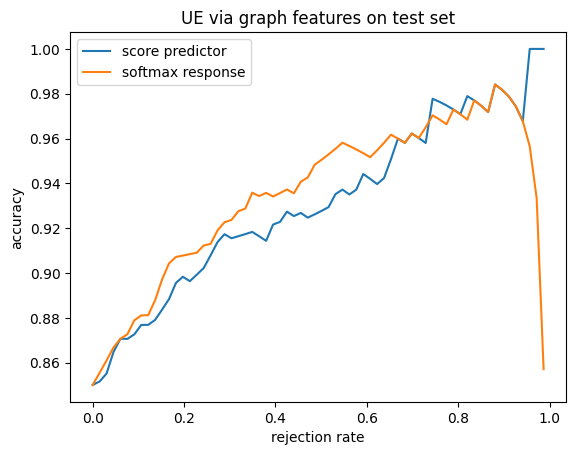

0.06833886843811698


In [ ]:
model = train_score_predictor(train_features, num_epochs=300, batch_size=32)

s, scores = test_score_predictor(model, val_features, val_labels, val_predicted_labels, batch_size=8)
print(s)

## Baselines

The first baseline displayed on the graphs below is Softmax Output (reject samples with lower softmax probability)

In [207]:
import torch.nn as nn
import tqdm
from tqdm import tqdm
from torch.nn.functional import dropout

Implemented methods reuse functions from the code provided by authors of the paper
"Uncertainty Estimation of Transformer Predictions for Misclassification Detection"
https://github.com/AIRI-Institute/uncertainty_transformers

In [265]:
def create_ue_estimator(
    model,
    ue_args,
    eval_metric,
    calibration_dataset,
    train_dataset,
    cache_dir,
    config=None,
):
    if ue_args.ue_type == "mc" or ue_args.ue_type == "mc-dc":
        return UeEstimatorMc(
            model, ue_args, eval_metric, calibration_dataset, train_dataset
        )
        raise ValueError()


def estimate(
    config,
    classifier,
    eval_metric,
    calibration_dataset,
    train_dataset,
    eval_dataset,
    eval_results,
    work_dir
):
    """Function for uncertainty estimation"""
    true_labels = eval_results["true_labels"]
    # create estimator
    ue_estimator = create_ue_estimator(
        classifier,
        config.ue,
        eval_metric,
        calibration_dataset=calibration_dataset,
        train_dataset=train_dataset,
        cache_dir=config.cache_dir,
        config=config,
    )
    # calc UE
    ue_results = ue_estimator(eval_dataset, true_labels)
    # save results
    eval_results.update(ue_results)
    print(ue_results)

"""Monte-Carlo Dropout utilities"""

class DropoutMC(torch.nn.Module):
    def __init__(self, p: float, activate=False):
        super().__init__()
        self.activate = activate
        self.p = p
        self.p_init = p

    def forward(self, x: torch.Tensor):
        return dropout(
            x, self.p, training=self.training or self.activate
        )


def convert_dropouts(model, ue_args):
    """This function replace all model dropouts with custom dropout layer."""
    dropout_ctor = lambda p, activate: DropoutMC(
        p=ue_args.inference_prob, activate=False
    )
    convert_to_mc_dropout(model, {"Dropout": dropout_ctor, "StableDropout": dropout_ctor})


def convert_to_mc_dropout(
    model, substitution_dict
):
    for i, layer in enumerate(list(model.children())):
        proba_field_name = "dropout_rate" if "flair" in str(type(layer)) else "p"
        module_name = list(model._modules.items())[i][0]
        layer_name = layer._get_name()
        proba_field_name = "drop_prob" if layer_name == "StableDropout" else proba_field_name #DeBERTA case
        if layer_name in substitution_dict.keys():
            model._modules[module_name] = substitution_dict[layer_name](
                p=getattr(layer, proba_field_name), activate=False
            )
        else:
            convert_to_mc_dropout(model=layer, substitution_dict=substitution_dict)


def activate_mc_dropout(
    model: torch.nn.Module, activate: bool, random: float = 0.0, verbose: bool = False
):
    for layer in model.children():
        if isinstance(layer, DropoutMC):
            if verbose:
                print(layer)
                print(f"Current DO state: {layer.activate}")
                print(f"Switching state to: {activate}")
            layer.activate = activate
            if activate and random:
                layer.p = random
            if not activate:
                layer.p = layer.p_init
        else:
            activate_mc_dropout(
                model=layer, activate=activate, random=random, verbose=verbose
            )


def softmax(logits):
    return np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)


class UeEstimatorMc:
    """Monte-Carlo Dropout base method"""
    def __init__(self, ue_args, eval_metric, calibration_dataset, train_dataset):
        self.ue_args = ue_args
        self.calibration_dataset = calibration_dataset
        self.eval_metric = eval_metric
        self.train_dataset = train_dataset

    def __call__(self, model, eval_dataset, eval_mask, true_labels=None):
        ue_args = self.ue_args
        eval_metric = self.eval_metric


        convert_dropouts(model, ue_args)
        activate_mc_dropout(model, activate=True, random=ue_args.inference_prob)

        eval_results = {}
        eval_results["sampled_probabilities"] = []
        eval_results["sampled_answers"] = []


        batch_size = 16
        
        N = eval_dataset.shape[0]
        predicted_labels = np.zeros(N)
        probs = np.zeros(N)
        for j in tqdm(np.arange(ue_args.committee_size)):
            with torch.no_grad():
                for i in range(0, N, batch_size):
                    x_batch = torch.tensor(eval_dataset[i:i+batch_size]).to(device)
                    mask_batch = torch.tensor(eval_mask[i:i+batch_size]).to(device)

                    logits_batch = model(x_batch, attention_mask=mask_batch).logits
                    probs_batch = softmax(logits_batch)
                    pred_probs_batch, pred_labels_batch = torch.max(probs_batch, dim=1)
                    pred_probs_batch = pred_probs_batch.detach().cpu().numpy()
                    pred_labels_batch = pred_labels_batch.detach().cpu().numpy()
                    probs[i:i+batch_size] = pred_probs_batch
                    predicted_labels[i:i+batch_size] = pred_labels_batch

            eval_results["sampled_probabilities"].append(probs.tolist())
            eval_results["sampled_answers"].append(predicted_labels.tolist())

        activate_mc_dropout(model, activate=False)

        return eval_results


def calc_score(probs, mode):
    if mode == "SMP":
        score = np.mean(probs, axis=1)
    elif mode == "PV":
        score = 1.0 - np.var(probs, axis=1)
    elif mode == "entropy":
        score = -np.sum(probs * np.log(probs), axis=1)
    return score

"""Malahanobis distance utilities"""

class BERTClassificationHeadIdentityPooler(torch.nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, model):
        super().__init__()
        self.pooler = model.bert.pooler

    def forward(self, features):
        x = features[:, 0, :]
        x = self.pooler(features)
        # print(x.shape)
        return x


class BERTClf(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, features):
        return features


def compute_centroids(train_features, train_labels):
    centroids = []
    for label in np.sort(np.unique(train_labels)):
        centroids.append(train_features[train_labels == label].mean(axis=0))
    return np.asarray(centroids)


def compute_covariance(centroids, train_features, train_labels):
    cov = np.zeros((train_features.shape[1], train_features.shape[1]))
    for c, mu_c in tqdm(enumerate(centroids)):
        for x in train_features[train_labels == c]:
            d = (x - mu_c)[:, None]
            cov += d @ d.T
    return cov / train_features.shape[0]


def mahalanobis_distance(train_features, train_labels, eval_features):
    centroids = compute_centroids(train_features, train_labels)
    sigma = compute_covariance(centroids, train_features, train_labels)
    diff = eval_features[:, None, :] - centroids[None, :, :]
    try:
        sigma_inv = np.linalg.inv(sigma)
    except:
        sigma_inv = np.linalg.pinv(sigma)
    dists = np.matmul(np.matmul(diff, sigma_inv), diff.transpose(0, 2, 1))
    dists = np.asarray([np.diag(dist) for dist in dists])
    return np.min(dists, axis=1)


class TextClassifier:
    def __init__(self, model):
        self.model = model

    def predict(self, data, mask, apply_softmax=False, return_preds=False):
        batch_size = 16
        N = data.shape[0]
        emb_dim = 768
        predicted_labels = np.zeros(N)
        probs = np.zeros((N, emb_dim))
        with torch.no_grad():
            for i in range(0, N, batch_size):
                x_batch = torch.tensor(data[i:i+batch_size]).to(device)
                mask_batch = torch.tensor(mask[i:i+batch_size]).to(device)

                logits_batch = model(x_batch, attention_mask=mask_batch).logits
                if apply_softmax:
                    probs_batch = softmax(logits_batch)
                else:
                    probs_batch = logits_batch
                if return_preds:
                    pred_probs_batch, pred_labels_batch = torch.max(probs_batch, dim=1)
                    pred_labels_batch = pred_labels_batch.detach().cpu().numpy()
                    predicted_labels[i:i+batch_size] = pred_labels_batch

                probs_batch = probs_batch.detach().cpu().numpy()
                probs[i:i+batch_size] = probs_batch

        if return_preds:
            return (probs, predicted_labels)
        return probs


class UeEstimatorMahalanobis:
    def __init__(self, ue_args, config, train_dataset):
        self.ue_args = ue_args
        self.config = config
        self.train_dataset = train_dataset

    def __call__(self, model, val_data, val_mask, val_labels, train_data, train_mask, train_labels, true_labels=None):
        # change head
        self.cls = TextClassifier(model)
        self.cls.model.bert.pooler = BERTClassificationHeadIdentityPooler(model)
        self.cls.model.classifier = BERTClf()

        eval_features = self.cls.predict(
            val_data, val_mask, apply_softmax=False, return_preds=False
        )

        train_features = self.cls.predict(
            train_data, train_mask, apply_softmax=False, return_preds=False
        )

        eval_results = {}
        eval_results["eval_labels"] = true_labels
        eval_results["mahalanobis_distance"] = mahalanobis_distance(
            train_features, train_labels, eval_features
        ).tolist()

        return eval_results

In [266]:
import transformers
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification

In [267]:
PRETRAINED_MODEL_PATH = "en-cola-finetuned/"

In [268]:
model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_PATH, cache_dir=None)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [269]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased", do_lower_case=False)

In [270]:
tokenized_train = train_data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_val = val_data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [271]:
def add_padding(tokenized_data):
    max_len = max([len(line) for line in tokenized_data.values])
    padded_data = np.array([line + [0] * (max_len - len(line)) for line in tokenized_data.values])
    #print(padded_cola_data.shape)
    return padded_data

In [272]:
# padding
padded_train_data = add_padding(tokenized_train)
print(padded_train_data.shape)

# attention mask
mask_train = (padded_train_data > 0).astype(int)
print(mask_train.shape)

(8551, 47)
(8551, 47)


In [273]:
# padding
padded_val_data = add_padding(tokenized_val)
print(padded_val_data.shape)
# attention mask
mask_val = (padded_val_data > 0).astype(int)
print(mask_val.shape)

(527, 31)
(527, 31)


In [274]:
device = "cpu"

Monte Carlo Dropout

In [299]:
class UEconfig:
    def __init__(self, ue_type="mc", dropout_type='MC', inference_prob=0.1, committee_size=8, dropout_subs='all'):
        self.ue_type = ue_type
        self.dropout_type = dropout_type
        self.inference_prob = inference_prob
        self.committee_size = committee_size
        self.dropout_subs = dropout_subs
        self.use_cache = True
        self.eval_passes = False
        self.calibrate = False
        self.use_selective = False

ue_config = UEconfig()

In [300]:
UE_estimator = UeEstimatorMc(ue_config, "accuracy", padded_val_data, padded_train_data)
ue_scores = UE_estimator(model, padded_val_data, mask_val)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:39<00:00, 34.94s/it]


In [302]:
res = np.array(ue_scores["sampled_probabilities"]).reshape(527, 8)
print(res.shape)

(527, 8)


In [303]:
predicted_labels = np.median(np.array(ue_scores["sampled_answers"]), axis=0)
print(len(predicted_labels))

527


In [304]:
predicted_labels = predicted_labels.astype(int)

In [305]:
uncertainty_scores = calc_score(res, mode="PV")

In [ ]:
from sklearn.metrics import accuracy_score

In [312]:
N = N_val
r_rate = [0]
step = 8
idx = np.argsort(uncertainty_scores)
val_idx = idx
total_accuracy = [accuracy_score(predicted_labels, val_labels)]
for i in range (step, N, step):
    idx = idx[:(N - i)]
    r_rate.append(i / N)
    total_accuracy.append(accuracy_score(predicted_labels[idx], val_labels[idx]))

In [313]:
# calculate area under rejection curve which is metric value
s0 = total_accuracy[0]
s = np.trapz(total_accuracy, dx=step / N)
print("MC Dropout Estimator metric value: ", s - s0)

MC Dropout Estimator metric value:  6.025483087579442e-05


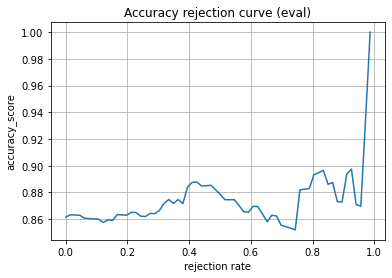

In [314]:
plt.xlabel("rejection rate")
plt.ylabel("accuracy_score")
plt.title("Accuracy rejection curve (eval)")
plt.grid()   
plt.plot(r_rate, total_accuracy) 
plt.show()

Mahalanobis distance-based uncertainty estimator

In [185]:
model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_PATH, cache_dir=None)
model.eval()
UE_estimator = UeEstimatorMahalanobis(ue_config, "accuracy", padded_train_data)
ue_scores = UE_estimator(model, padded_val_data, mask_val, val_labels, padded_train_data, mask_train, train_labels)

2it [00:35, 17.92s/it]


In [187]:
N = N_val
r_rate = [0]
step = 8
dists = ue_scores["mahalanobis_distance"]
idx = np.argsort(dists)
val_idx = idx
total_accuracy = [accuracy_score(val_predicted_labels, val_labels)]
for i in range (step, N, step):
    idx = idx[:(N - i)]
    r_rate.append(i / N)
    total_accuracy.append(accuracy_score(val_predicted_labels[idx], val_labels[idx]))

In [189]:
# calculate area under rejection curve which is metric value
s0 = total_accuracy[0]
s = np.trapz(total_accuracy, dx=step / N)
print("Mahalanobis Estimator metric value: ", s - s0)

Mahalanobis Estimator metric value:  0.08328522773373348


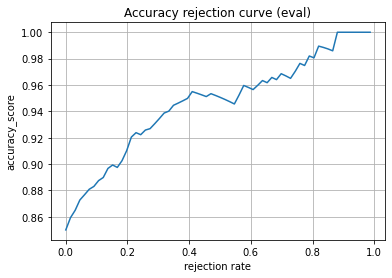

In [190]:
plt.xlabel("rejection rate")
plt.ylabel("accuracy_score")
plt.title("Accuracy rejection curve (eval)")
plt.grid()   
plt.plot(r_rate, total_accuracy) 
plt.show()

## Accuracy rejection for features

In [ ]:
baseline_df = pd.read_csv("/content/sample_data/train_rejection.csv", sep=",")
accuracy_3 = baseline_df["accuracy"].values

In [ ]:
train_features_graph = np.load("/content/sample_data/train_s_w_e_v_c_b0b1_m_k_lists_array_6.npy")
train_features_graph = np.mean(train_features_graph, axis=(0, 1, 4))
train_features_graph = train_features_graph[:7].T

In [ ]:
train_features_ripser = np.load("/content/sample_data/train_ripser.npy")
train_features_ripser = np.mean(train_features_ripser, axis=(0, 1))
train_features_ripser = train_features_ripser[3, 0]

In [ ]:
def features_rejection(N, step, feature, true_labels, predicted_labels):
    idx = np.argsort(feature)[::-1]
    r_rate = [0]
    r_accuracy = [accuracy_score(true_labels, predicted_labels)]
    for i in range (step, N, step):
        idx = idx[:(N - i)]
        r_rate.append(i / N)
        r_accuracy.append(accuracy_score(true_labels[idx], predicted_labels[idx]))
    return r_rate, r_accuracy

In [ ]:
def accuracy_rejection(N, step, probs, true_labels, predicted_labels):
    idx = np.argsort(probs)[::-1]
    r_rate = [0]
    r_accuracy = [accuracy_score(true_labels, predicted_labels)]
    for i in range (step, N, step):
        idx = idx[:(N - i)]
        r_rate.append(i / N)
        r_accuracy.append(accuracy_score(true_labels[idx], predicted_labels[idx]))
    return r_rate, r_accuracy

In [ ]:
r_rate, accuracy_0 = features_rejection(N_train, 32, train_features_ripser[:, 9], train_labels, train_predicted_labels)
r_rate, accuracy_3 = features_rejection(N_train, 32, train_features_graph[:, 3], train_labels, train_predicted_labels)
r_rate, accuracy_4 = features_rejection(N_train, 32, train_features_graph[:, 4], train_labels, train_predicted_labels)
r_rate, accuracy_5 = features_rejection(N_train, 32, train_features_ripser[:, 10], train_labels, train_predicted_labels)

In [ ]:
graph_feature_names=[
    's', # 1 - number of strongly connected components
    'w', # 2 - number of weakly connected components
    'e', # 3 - number of edges
    'v', # 4 - average vertex degree
    'c', # 5 - number of (directed) simple cycles
    'b0', # 6 - Betti numbers
    'b1', # 7 - Betti numbers
]

In [ ]:
ripser_feature_names=[
    'h0_s', # 1 - sum of lengths
    'h0_e', # 2 - entropy
    'h0_t_d', # 3 - time of death for the longest barcode
    'h0_n_d_m_t0.75', # 4 - number of barcodes with death time > threshold
    'h0_n_d_m_t0.5', # 5 - number of barcodes with death time > threshold
    'h0_n_d_l_t0.25', # 6 - number of barcodes with death time < threshold
    'h1_t_b', # 7 - time of birth for the longest barcode
    'h1_n_b_m_t0.25', # 8 - number of barcodes with birth time > threshold
    'h1_n_b_l_t0.95', # 9 - number of barcodes with birth time < threshold
    'h1_n_b_l_t0.70', # 10 - number of barcodes with birth time < threshold
    'h1_s', # 11 - sum of lengths
    'h1_e', # 12 - entropy
    'h1_v', # 13 - variance of lenghts
    'h1_nb' # 14 - number of barcodes in dim
]

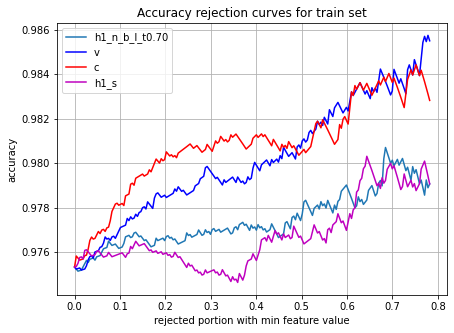

In [ ]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)
plt.plot(r_rate[:210], accuracy_0[:210], label='h1_n_b_l_t0.70')
plt.plot(r_rate[:210], accuracy_3[:210], color="b", label='v')
plt.plot(r_rate[:210], accuracy_4[:210], color="r", label='c')
plt.plot(r_rate[:210], accuracy_5[:210], color="m", label='h1_s')
plt.xlabel("rejected portion with min feature value")
plt.ylabel("accuracy")
plt.title("Accuracy rejection curves for train set")
plt.grid()
plt.legend()
plt.savefig("corr_ripser_train.png")
plt.show()

In [ ]:
val_features_graph = np.load("/content/sample_data/dev_s_w_e_v_c_b0b1_m_k_lists_array_6.npy")
val_features_graph = val_features_graph[0, 0, :, :, :]
val_features_graph = np.mean(val_features_graph, axis=2)
val_features_graph = val_features_graph[:7].T

In [ ]:
val_features_ripser = np.load("/content/sample_data/dev_ripser.npy")
val_features_ripser = np.mean(val_features_ripser, axis=(0, 1))

In [ ]:
r_rate, accuracy_0 = features_rejection(N_val, 2, val_features_ripser[:, 9], val_labels, val_predicted_labels)
r_rate, accuracy_3 = features_rejection(N_val, 2, val_features_graph[:, 3], val_labels, val_predicted_labels)
r_rate, accuracy_4 = features_rejection(N_val, 2, val_features_graph[:, 4], val_labels, val_predicted_labels)
r_rate, accuracy_5 = features_rejection(N_val, 2, val_features_ripser[:, 12], val_labels, val_predicted_labels)

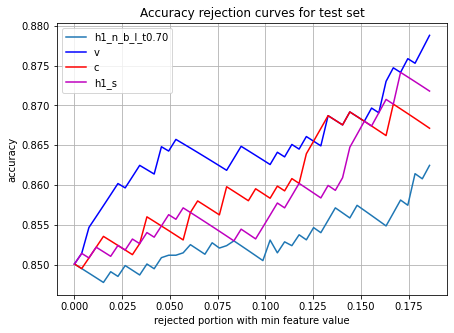

In [ ]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)
plt.plot(r_rate[:50], accuracy_0[:50], label='h1_n_b_l_t0.70')
plt.plot(r_rate[:50], accuracy_3[:50], color="b", label='v')
plt.plot(r_rate[:50], accuracy_4[:50], color="r", label='c')
plt.plot(r_rate[:50], accuracy_5[:50], color="m", label='h1_s')
plt.xlabel("rejected portion with min feature value")
plt.ylabel("accuracy")
plt.title("Accuracy rejection curves for test set")
plt.grid()
plt.legend()
plt.savefig("corr_ripser_test.png")
plt.show()